# MOA Evaluation using enrichment analysis

- Adopted here: https://www.nature.com/articles/s41467-019-10154-8
- Explained here: https://yulab-smu.github.io/clusterProfiler-book/chapter2.html

### Procedure:
1. Compute similarity / correlation / affinity matrix
1. Define MOA matching criteria based on metadata
  - https://github.com/carpenterlab/2018_rohban_natcomm/blob/master/code/moa_evaluations.R#L67
  - https://github.com/carpenterlab/2018_rohban_natcomm/blob/master/code/evaluate.R#L190
1. Find the threshold of top connections (percentile)
1. Run enrichment analysis (one-sided version of Fisher's exact test)
  - https://github.com/carpenterlab/2018_rohban_natcomm/blob/master/code/moa_evaluations.R#L97
  - https://github.com/carpenterlab/2018_rohban_natcomm/blob/master/code/evaluate.R#L205

In [1]:
import pandas as pd
import numpy as np
import seaborn as sb
import matplotlib.pyplot as plt
import pickle
import sys
import sklearn

sys.path.append("../profiling/")

import metrics
import quality
import profiling

# Load correlation matrix

In [2]:
#CORR_MATRIX = "data/correlation_matrix.csv"
CORR_MATRIX = "data/correlation_matrix_efn128_trainval_manual_oldtop_100ep_adam0001_queue_conv6a.csv"
OUT_RESUTS = "data/trained_features.pkl"

In [3]:
# df = pd.read_csv("data/cr_median.csv")
# clean = df[df["Unnamed: 0"].isin(df.groupby(["Var1","Var2","value"])["Unnamed: 0"].max().reset_index()["Unnamed: 0"])]
# clean.to_csv("data/cr_median_clean.csv", index=False)

In [4]:
X, Y = profiling.load_correlation_matrix(CORR_MATRIX)

In [5]:
# Z = Y.groupby(["Var1"]).max().reset_index()
# Z[["Var1", "Metadata_moa.x", "Metadata_Plate_Map_Name.x"]].to_csv("data/BBBC022_MOA_MATCHES.csv")

# MOA matching

In [6]:
Y.groupby("Metadata_moa.x")["Var1"].count()

Metadata_moa.x
11-beta hydroxysteroid dehydrogenase inhibitor                                                                                    2
3-ketoacyl CoA thiolase inhibitor                                                                                                 1
5 alpha reductase inhibitor                                                                                                       1
ABC transporter expression enhancer|high conductance calcium activated potassium blocker|LXR agonist|potassium channel blocker    1
ACAT inhibitor                                                                                                                    1
                                                                                                                                 ..
vitamin B                                                                                                                         1
vitamin B2                                                   

In [7]:
moa_matches = []
for k,r in Y.iterrows():
    moas = r["Metadata_moa.x"].split("|")
    candidates = []
    for m in moas:
        candidates.append(Y["Metadata_moa.x"].str.find(m) != -1)
    matches = candidates[0]
    for c in candidates:
        matches = matches | c
    moa_matches.append(matches)

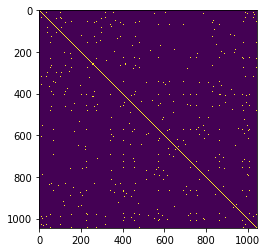

In [8]:
moa_matches = np.asarray(moa_matches)
plt.imshow(moa_matches)

# Enrichment analysis

In [9]:
results = []
Z = np.asarray(X[Y.Var1])
ut_idx = np.triu_indices(moa_matches.shape[1], k=1)

for p in np.arange(98, 99.7, 0.2):
    r = quality.enrichment_analysis_matrix(Z[ut_idx], moa_matches[ut_idx], p)
    results.append(r)

R = pd.DataFrame(data=results)

98.0 0.42272698026525346
[[   692  10218]
 [  5011 529569]] 545490
98.2 0.4342924307561768
[[   657   9162]
 [  5046 530625]] 545490
98.4 0.44740390281684084
[[   629   8099]
 [  5074 531688]] 545490
98.60000000000001 0.46212674221929184
[[   604   7033]
 [  5099 532754]] 545490
98.80000000000001 0.47936543203911963
[[   565   5981]
 [  5138 533806]] 545490
99.00000000000001 0.5020958946268851
[[   502   4953]
 [  5201 534834]] 545490
99.20000000000002 0.5290998941898735
[[   442   3922]
 [  5261 535865]] 545490
99.40000000000002 0.5666476080974817
[[   359   2914]
 [  5344 536873]] 545490
99.60000000000002 0.6231443365739934
[[   243   1939]
 [  5460 537848]] 545490


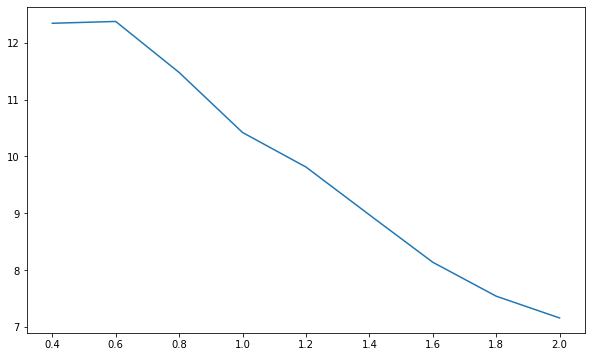

In [10]:
plt.figure(figsize=(10,6))
plt.plot(100-R["percentile"], R["ods_ratio"])

# Average precision analysis

In [11]:
def average_precision(corr_matrix, moa_matches, rank_pos=None):
    results = []
    for i in range(corr_matrix.shape[0]):
        rank = np.argsort(-corr_matrix[i,:])
        ap = metrics.average_precision(moa_matches[i, rank[1:rank_pos]])
        results.append(ap)
    return results

In [12]:
positions = [x for x in range(5,55,5)]
CRM = np.asarray(X[Y.Var1])
map_at = [np.mean( average_precision(CRM, moa_matches, pos) ) for pos in positions]

Mean Average Precision - Full rank: 0.054491828468139845


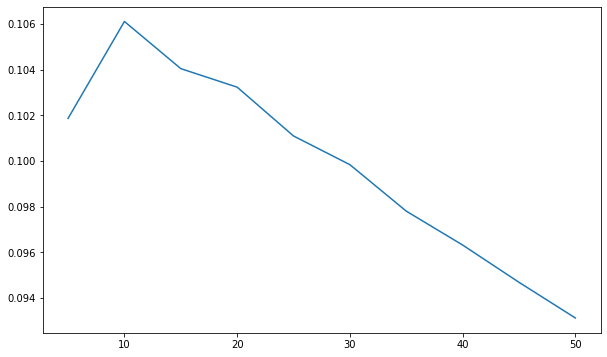

In [13]:
plt.figure(figsize=(10,6))
plt.plot(positions, map_at)
print("Mean Average Precision - Full rank:", np.mean( average_precision(CRM, moa_matches) ))

In [14]:
top_1percent = max(int(X.shape[0]*0.01), 10)
top_prec = average_precision(CRM, moa_matches, top_1percent)
print("Average Precision At Top 1% => ", np.mean(top_prec))

Average Precision At Top 1% =>  0.10610519127906345


# Recall analysis

In [15]:
def recall_at(corr_matrix, moa_matches, rank_pos=None):
    results = []
    for i in range(corr_matrix.shape[0]):
        rank = np.argsort(-corr_matrix[i,:])
        rc = np.sum(moa_matches[i, rank[1:rank_pos]]) / np.sum(moa_matches[i,:])
        results.append(rc)
    return results

In [16]:
recall = [np.mean( recall_at(CRM, moa_matches, pos) ) for pos in positions]

Average Recall - Top 50:  0.09176675110014354


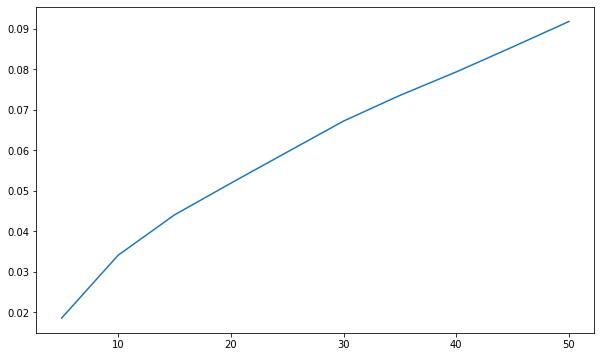

In [17]:
plt.figure(figsize=(10,6))
plt.plot(positions, recall)
print("Average Recall - Top 50: ", np.mean( recall_at(CRM, moa_matches, 50) ))

In [18]:
avg_recall_at_top = np.mean( recall_at(CRM, moa_matches, top_1percent) )
print("Average Recall At Top 1% => ", avg_recall_at_top)

Average Recall At Top 1% =>  0.034041603096724264


# Interpolated Recall-Precision Curve

/home/jupyter-jcaicedo@broadinst-d9764/.local/lib/python3.7/site-packages/sklearn/metrics/ranking.py:528: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]


Mean Average Precision (MAP): 	 0.05692016031989682
Area Under the PR curve: 	 0.056899823149955814


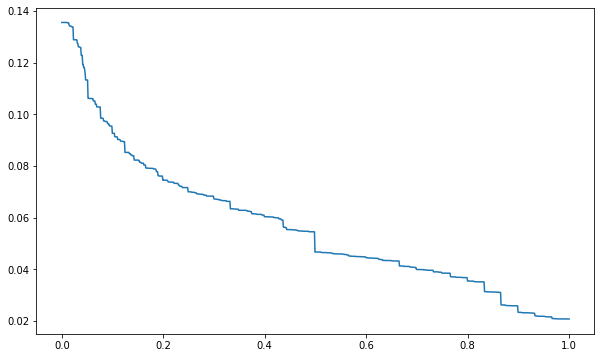

In [19]:
recall_axis, average_precision = metrics.interpolated_precision_recall_curve(moa_matches, CRM)

plt.figure(figsize=(10,6))
plt.plot(recall_axis, average_precision)

print("Mean Average Precision (MAP): \t", np.mean(average_precision))
print("Area Under the PR curve: \t", sklearn.metrics.auc(recall_axis, average_precision))

# Save Results

In [20]:
results = {
    "enrichment": R,
    "ranking": positions,
    "avg_precision": map_at,
    "recall": recall,
    "avg_prec@top1": np.mean(top_prec),
    "avg_recall@top1": avg_recall_at_top,
    "recall_axis": recall_axis,
    "precision_axis": average_precision,
    "mean_average_precision": np.mean(average_precision)
}

with open(OUT_RESUTS, "bw") as out:
    pickle.dump(results, out)